# **0. Load Preliminary Functions**

# a. Import Libraries and Functions

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
%matplotlib inline

# b. MNIST Data Loader

In [7]:
def binarize_image(tensor):
    return (tensor > 0.5).float()

tensor_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(binarize_image)
])

batch_size = 128
train_dataset = datasets.MNIST(root = "./data",
									train = True,
									download = True,
									transform = tensor_transform)
test_dataset = datasets.MNIST(root = "./data",
									train = False,
									download = True,
									transform = tensor_transform)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
							   batch_size = batch_size,
								 shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
							   batch_size = batch_size,
								 shuffle = False)


# **1. PixelCNN**


# a. Training Function

In [8]:
bce = F.binary_cross_entropy

def train(dataloader, model, optimizer, epochs):
    losses = []

    for epoch in tqdm(range(epochs), desc='Epochs'):
        running_loss = 0.0
        batch_progress = tqdm(dataloader, desc='Batches', leave=False)

        for iter, (images, labels) in enumerate(batch_progress):
            images = images.to(device)
            tgt = images.clone()
            pred = model(images)
            loss = bce(pred, tgt)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            avg_loss = running_loss * batch_size / len(train_dataset)
            losses.append(loss.item())

        tqdm.write(f'----\nEpoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}\n')

    return losses


# b. Masked Convolution

In [12]:
class MaskedConv2d(nn.Conv2d):
    ##################
    ### Problem 2(a): Implement MaskedConv2d
    def __init__(self, conv_type, *args, **kwargs):
        super().__init__(*args, **kwargs)
        assert conv_type in ("A", "B")
        self.conv_type = conv_type
        H, W = self.weight.shape[-2:]
        mask = torch.zeros((H, W), dtype=torch.float32)
        mask[: H // 2] = 1
        mask[H // 2, : W // 2] = 1
        if conv_type == "B":
            mask[H // 2, W // 2] = 1
        mask = mask.view((1, 1, H, W))
        self.register_buffer("mask", mask, False)

    def forward(self, x):
        self.weight.data *= self.mask
        return super().forward(x)

    ##################

In [13]:
class ResidualBlock(nn.Module):
    """
    https://arxiv.org/pdf/1601.06759
    https://zhuanlan.zhihu.com/p/461693342

    Residual Block: conv1x1 -> conv3x3 -> conv1x1
    """

    def __init__(self, in_channels):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // 2, 1), nn.ReLU(inplace=True)
        )
        # masked conv2d
        self.conv2 = nn.Sequential(
            MaskedConv2d("B", in_channels // 2, in_channels // 2, 3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels // 2, in_channels, 1), nn.ReLU(inplace=True)
        )

    def forward(self, x):
        inputs = x
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return inputs + x


class PixelCNN(nn.Module):
    ##################
    ### Problem 2(b): Implement PixelCNN
    """
    https://arxiv.org/pdf/1601.06759
    https://zhuanlan.zhihu.com/p/461693342
    """

    def __init__(
        self,
        in_channels=1,
        channels=128,
        out_channels=1,
        n_residual_blocks=5,
        check_shape=False,
    ):
        super().__init__()
        self.check_shape = check_shape

        self.stem = nn.Sequential(
            MaskedConv2d("A", in_channels, channels, 7, padding=3),
            nn.ReLU(inplace=True),
        )
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(channels) for _ in range(n_residual_blocks)]
        )
        self.head = nn.Sequential(
            MaskedConv2d("B", channels, channels, 1),
            nn.ReLU(inplace=True),
            MaskedConv2d("B", channels, channels, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, out_channels, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        self.print_shape_if_check(x)
        x = self.stem(x)
        self.print_shape_if_check(x)
        x = self.res_blocks(x)
        self.print_shape_if_check(x)
        x = self.head(x)
        self.print_shape_if_check(x)
        return x

    def print_shape_if_check(self, x):
        if self.check_shape:
            print(x.shape)

    ##################


model = PixelCNN(check_shape=1)
with torch.no_grad():
    print(model(train_dataset[0][0].unsqueeze(0))[0, 0, :5, :5])  # for checking the shape

torch.Size([1, 1, 28, 28])
torch.Size([1, 128, 28, 28])
torch.Size([1, 128, 28, 28])
torch.Size([1, 1, 28, 28])
tensor([[0.5019, 0.5021, 0.5021, 0.5021, 0.5021],
        [0.5017, 0.5020, 0.5020, 0.5020, 0.5020],
        [0.5017, 0.5020, 0.5019, 0.5019, 0.5019],
        [0.5017, 0.5020, 0.5019, 0.5019, 0.5019],
        [0.5017, 0.5020, 0.5019, 0.5019, 0.5019]])


# d. Training

In [ ]:
##################
### Problem 2(c): Training
epochs = 30
model = PixelCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# log = train(train_loader, model, optimizer, epochs)
model.load_state_dict(torch.load('./models/PixelCNN.pt'))
print(model)
##################


PixelCNN(
  (stem): Sequential(
    (0): MaskedConv2d(1, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): ReLU(inplace=True)
  )
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): MaskedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
      (conv3): Sequential(
        (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): MaskedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
      (conv3): Sequential(
        (0): Conv2d(64, 128, kernel_size=(1, 1), 

# e. Evaluation (Reconstruction)

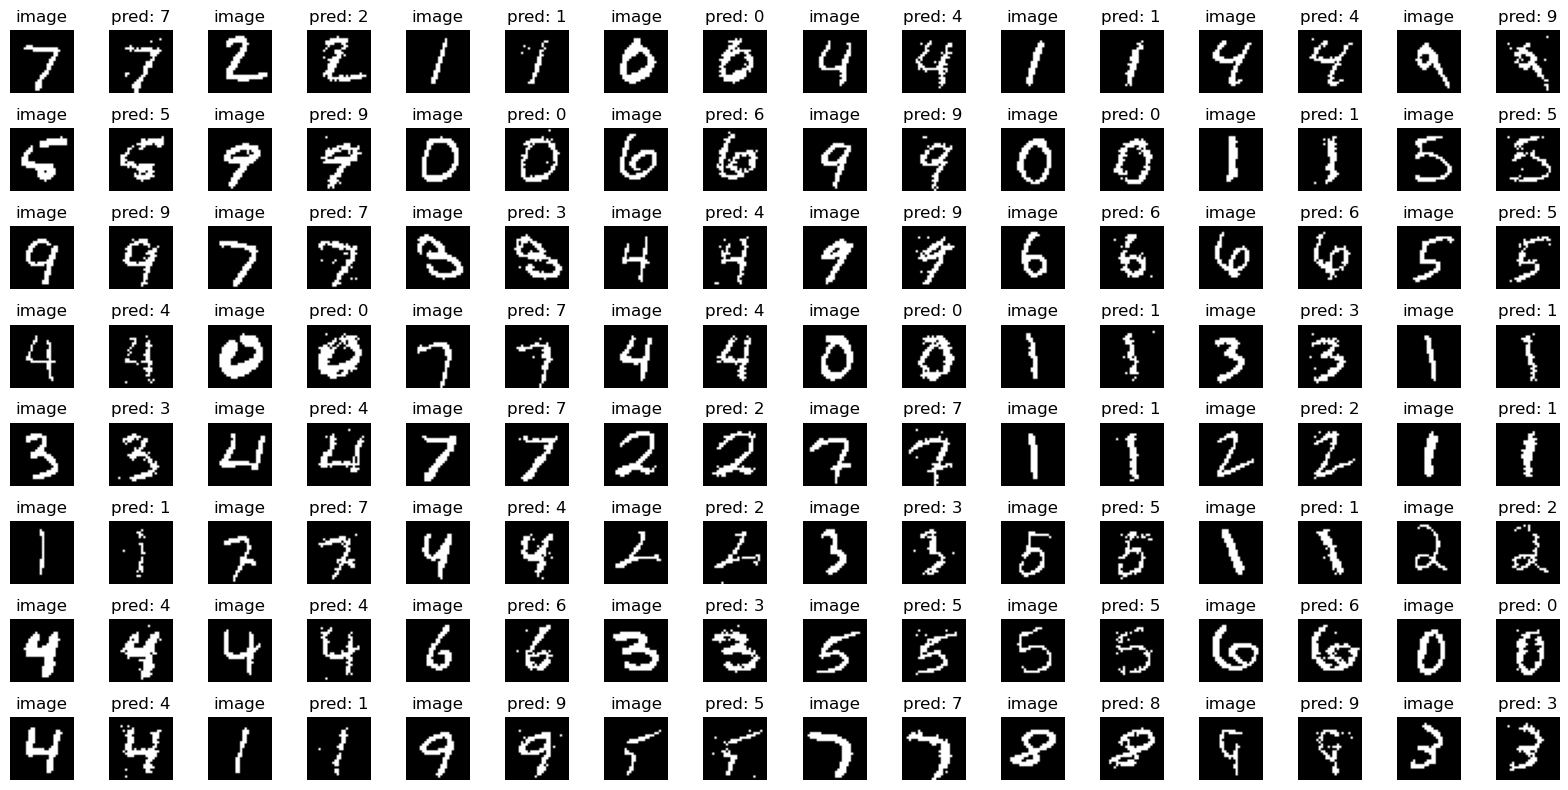

In [27]:
H, W = 28, 28

with torch.no_grad():
    for iter, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        pred = model(images)

        for i in range(H):
            for j in range(W):
                pred[:, :, i, j] = torch.bernoulli(
                    pred[:, :, i, j], out=pred[:, :, i, j]
                )
        break

samples = pred.detach().cpu().numpy().transpose(0, 2, 3, 1)
samples2 = images.detach().cpu().numpy().transpose(0, 2, 3, 1)
labels = labels.detach().cpu().numpy()
fig, axes = plt.subplots(8, 16, figsize=(16, 8))

for i in range(64):
    sample = samples[i]
    row, col = divmod(i, 8)
    axes[row, 2 * col].imshow(samples2[i], cmap="gray")
    axes[row, 2 * col].set_title('image')
    axes[row, 2 * col].axis("off")
    axes[row, 2 * col + 1].imshow(sample, cmap="gray")
    axes[row, 2 * col + 1].set_title(f'pred: {labels[i]}')
    axes[row, 2 * col + 1].axis("off")

fig.tight_layout()
plt.show()

# f. Evaluation (Generation)

  0%|          | 0/28 [00:00<?, ?it/s]

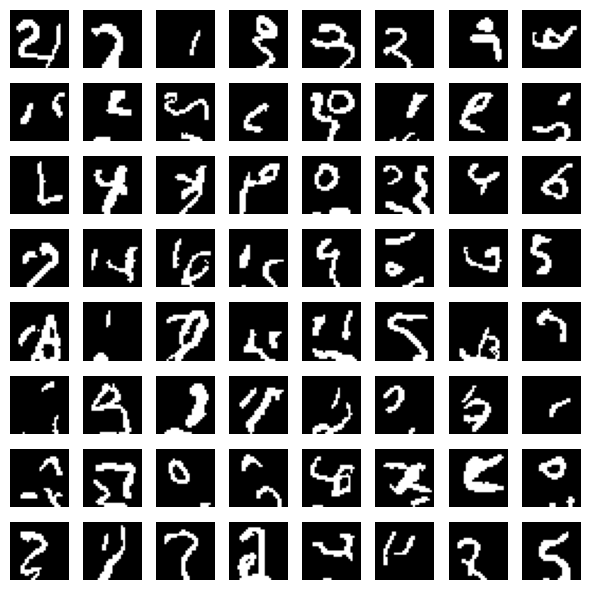

In [39]:
samples = torch.zeros(size=(64, 1, H, W)).to(device)
with torch.no_grad():
    for i in tqdm(range(H)):
        for j in range(W):
            if j > 0 and i > 0:
                out = model(samples)
                samples[:, :, i, j] = torch.bernoulli(out[:, :, i, j], out=samples[:, :, i, j])

samples = samples.cpu().numpy().transpose(0, 2, 3, 1)
fig, axes = plt.subplots(8, 8, figsize=(6, 6))

for i in range(64):
    sample = samples[i]
    row, col = divmod(i, 8)
    axes[row, col].imshow(sample, cmap='gray')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

  0%|          | 0/28 [00:00<?, ?it/s]

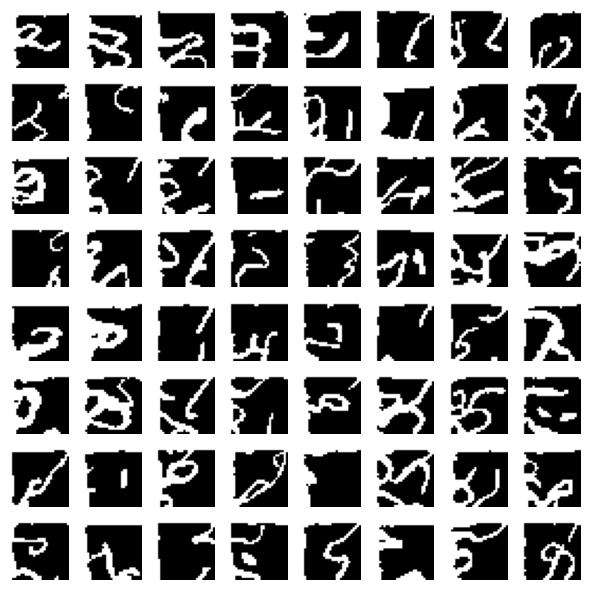

In [40]:
samples = torch.ones(size=(64, 1, H, W)).to(device)
with torch.no_grad():
    for i in tqdm(range(H)):
        for j in range(W):
            if j > 0 and i > 0:
                out = model(samples)
                samples[:, :, i, j] = torch.bernoulli(out[:, :, i, j], out=samples[:, :, i, j])

samples = samples.cpu().numpy().transpose(0, 2, 3, 1)
fig, axes = plt.subplots(8, 8, figsize=(6, 6))

for i in range(64):
    sample = samples[i]
    row, col = divmod(i, 8)
    axes[row, col].imshow(sample, cmap='gray')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# **2. Conditional PixelCNN**


# a. Training Function

In [50]:
def train_cond(dataloader, model, optimizer, epochs, n_classes):
    losses = []

    for epoch in tqdm(range(epochs), desc='Epochs'):
        running_loss = 0.0
        batch_progress = tqdm(dataloader, desc='Batches', leave=False)

        for iter, (images, labels) in enumerate(batch_progress):
            images = images.to(device) # (batch_size, 1, 28, 28)
            labels = labels.to(device) # (batch_size,)
            tgt = images.clone()
            labels = F.one_hot(labels, num_classes=n_classes).float() # (batch_size, n_classes)
            pred = model(images, labels)
            loss = bce(pred, tgt)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            avg_loss = running_loss * batch_size / len(train_dataset)
            losses.append(loss.item())

        tqdm.write(f'----\nEpoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}\n')

    return losses

# b. Conditional Masked Convolution

In [9]:
class ConditionalMaskedConv2d(nn.Module):
    ##################
    ### Problem 3(b): Implement ConditionalMaskedConv2d
    def __init__(
        self,
        in_channels,
        kernel_size=3,
        dilation=1,
        num_classes=10,
        bn=False,
        conditional=True,
    ):
        """
        Gated Convolution block implemented the computation graph shown above.
        """
        super().__init__()

        padding = dilation * (kernel_size - 1) // 2
        self.conv_vert = VerticalStackConv(
            "B",
            in_channels,
            2 * in_channels,
            kernel_size,
            padding=padding,
            dilation=dilation,
        )
        self.conv_horiz = HorizontalStackConv(
            "B",
            in_channels,
            2 * in_channels,
            kernel_size,
            padding=padding,
            dilation=dilation,
        )
        self.conv_vert_to_horiz = nn.Conv2d(
            2 * in_channels, 2 * in_channels, kernel_size=1
        )
        self.conv_horiz_1x1 = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        if bn:
            self.bn = nn.ModuleList(
                [nn.BatchNorm2d(2 * in_channels) for _ in range(3)]
                + [nn.BatchNorm2d(in_channels)]
            )
        else:
            self.bn = [nn.Identity() for _ in range(4)]
        self.conditional = conditional
        if conditional:
            self.V_v = nn.Parameter(torch.randn(in_channels, num_classes), requires_grad=True)
            self.V_h = nn.Parameter(torch.randn(in_channels, num_classes), requires_grad=True)

    def forward(self, v_stack, h_stack, class_condition, print_shape=False):
        # Vertical stack (left)
        v_stack_feat = self.bn[0](self.conv_vert(v_stack))
        v_val, v_gate = v_stack_feat.chunk(2, dim=1)
        v_stack_out = torch.tanh(v_val) * torch.sigmoid(v_gate)
        if self.conditional:
            v_stack_out = v_stack_out + (self.V_v @ class_condition.T).T[..., None, None]
        if print_shape:
            print(
                f"v_stack: {v_stack.shape}, v_stack_feat: {v_stack_feat.shape}, v_val: {v_val.shape}, v_gate: {v_gate.shape}, v_stack_out: {v_stack_out.shape}"
            )

        # Horizontal stack (right)
        h_stack_feat = self.bn[1](self.conv_horiz(h_stack))
        h_stack_feat = h_stack_feat + self.bn[2](self.conv_vert_to_horiz(v_stack_feat))
        h_val, h_gate = h_stack_feat.chunk(2, dim=1)
        h_stack_feat = torch.tanh(h_val) * torch.sigmoid(h_gate)
        if self.conditional:
            h_stack_feat = h_stack_feat + (self.V_h @ class_condition.T).T[..., None, None]
        h_stack_out = self.bn[3](self.conv_horiz_1x1(h_stack_feat))
        h_stack_out = h_stack_out + h_stack
        if print_shape:
            print(
                f"h_stack: {h_stack.shape}, h_stack_feat: {h_stack_feat.shape}, h_val: {h_val.shape}, h_gate: {h_gate.shape}, h_stack_out: {h_stack_out.shape}"
            )

        return v_stack_out, h_stack_out

    ##################


class MaskedConv2d2(nn.Conv2d):
    """
    Implements a conv2d with mask applied on its weights.

    Args:
        mask (torch.Tensor): the mask tensor.
        in_channels (int) - Number of channels in the input image.
        out_channels (int) - Number of channels produced by the convolution.
        kernel_size (int or tuple) - Size of the convolving kernel
    """

    def __init__(self, mask, in_channels, out_channels, kernel_size, **kwargs):
        super().__init__(in_channels, out_channels, kernel_size, **kwargs)
        self.register_buffer("mask", mask[None, None])

    def forward(self, x):
        self.weight.data *= self.mask  # mask weights
        return super().forward(x)


class VerticalStackConv(MaskedConv2d2):

    def __init__(self, mask_type, in_channels, out_channels, kernel_size, **kwargs):
        # Mask out all pixels below. For efficiency, we could also reduce the kernel
        # size in height (k//2, k), but for simplicity, we stick with masking here.
        self.mask_type = mask_type

        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)
        mask = torch.zeros(kernel_size)
        mask[: kernel_size[0] // 2, :] = 1.0
        if self.mask_type == "B":
            mask[kernel_size[0] // 2, :] = 1.0

        super().__init__(mask, in_channels, out_channels, kernel_size, **kwargs)


class HorizontalStackConv(MaskedConv2d2):

    def __init__(self, mask_type, in_channels, out_channels, kernel_size, **kwargs):
        # Mask out all pixels on the left. Note that our kernel has a size of 1
        # in height because we only look at the pixel in the same row.
        self.mask_type = mask_type

        if isinstance(kernel_size, int):
            kernel_size = (1, kernel_size)
        assert kernel_size[0] == 1
        if "padding" in kwargs:
            if isinstance(kwargs["padding"], int):
                kwargs["padding"] = (0, kwargs["padding"])

        mask = torch.zeros(kernel_size)
        mask[:, : kernel_size[1] // 2] = 1.0
        if self.mask_type == "B":
            mask[:, kernel_size[1] // 2] = 1.0

        super().__init__(mask, in_channels, out_channels, kernel_size, **kwargs)

# c. Model

In [10]:
class ConditionalPixelCNN(nn.Module):
    ##################
    ### Problem 3(b): Implement ConditionalPixelCNN
    def __init__(
        self,
        num_classes,
        in_channels,
        channels,
        out_channels,
        bn=False,
        conditional=True,
    ):
        super().__init__()

        # Initial first conv with mask_type A
        self.conv_vstack = VerticalStackConv("A", in_channels, channels, 3, padding=1)
        self.conv_hstack = HorizontalStackConv("A", in_channels, channels, 3, padding=1)
        # Convolution block of PixelCNN. use dilation instead of
        # downscaling used in the encoder-decoder architecture in PixelCNN++
        self.conv_layers = nn.ModuleList(
            [
                ConditionalMaskedConv2d(channels, bn=bn, conditional=conditional, num_classes=num_classes),
                ConditionalMaskedConv2d(channels, bn=bn, dilation=2, conditional=conditional, num_classes=num_classes),
                ConditionalMaskedConv2d(channels, bn=bn, conditional=conditional, num_classes=num_classes),
                ConditionalMaskedConv2d(channels, bn=bn, dilation=4, conditional=conditional, num_classes=num_classes),
                ConditionalMaskedConv2d(channels, bn=bn, conditional=conditional, num_classes=num_classes),
                ConditionalMaskedConv2d(channels, bn=bn, dilation=2, conditional=conditional, num_classes=num_classes),
                ConditionalMaskedConv2d(channels, bn=bn, conditional=conditional, num_classes=num_classes),
            ]
        ) # fmt:skip

        # Output classification convolution (1x1)
        self.conv_out = nn.Sequential(
            nn.Conv2d(channels, out_channels, kernel_size=1), nn.Sigmoid()
        )

    def forward(self, x, class_condition, print_shape=False):
        # first convolutions
        v_stack = self.conv_vstack(x)
        h_stack = self.conv_hstack(x)

        if print_shape:
            print(f"x: {x.shape}, v_stack: {v_stack.shape}, h_stack: {h_stack.shape}")
        # Gated Convolutions
        for layer in self.conv_layers:
            v_stack, h_stack = layer(v_stack, h_stack, class_condition=class_condition, print_shape=print_shape)
        # 1x1 classification convolution
        # Apply ELU before 1x1 convolution for non-linearity on residual connection
        out = self.conv_out(F.elu(h_stack))
        return out

    ##################


with torch.no_grad():
    images, label = train_dataset[0][0][None], train_dataset[0][1]
    label = F.one_hot(torch.tensor(label), num_classes=10).float()
    print(images.shape, label)
    model = ConditionalPixelCNN(
        num_classes=10, in_channels=1, channels=64, out_channels=1
    )
    # model.conv_layers[0](train_dataset[0][0][None], print_shape=1)
    model.forward(images, label[None], print_shape=1)

torch.Size([1, 1, 28, 28]) tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
x: torch.Size([1, 1, 28, 28]), v_stack: torch.Size([1, 64, 28, 28]), h_stack: torch.Size([1, 64, 28, 28])
v_stack: torch.Size([1, 64, 28, 28]), v_stack_feat: torch.Size([1, 128, 28, 28]), v_val: torch.Size([1, 64, 28, 28]), v_gate: torch.Size([1, 64, 28, 28]), v_stack_out: torch.Size([1, 64, 28, 28])
h_stack: torch.Size([1, 64, 28, 28]), h_stack_feat: torch.Size([1, 64, 28, 28]), h_val: torch.Size([1, 64, 28, 28]), h_gate: torch.Size([1, 64, 28, 28]), h_stack_out: torch.Size([1, 64, 28, 28])
v_stack: torch.Size([1, 64, 28, 28]), v_stack_feat: torch.Size([1, 128, 28, 28]), v_val: torch.Size([1, 64, 28, 28]), v_gate: torch.Size([1, 64, 28, 28]), v_stack_out: torch.Size([1, 64, 28, 28])
h_stack: torch.Size([1, 64, 28, 28]), h_stack_feat: torch.Size([1, 64, 28, 28]), h_val: torch.Size([1, 64, 28, 28]), h_gate: torch.Size([1, 64, 28, 28]), h_stack_out: torch.Size([1, 64, 28, 28])
v_stack: torch.Size([1, 64, 28, 28])

# d. Training

In [ ]:
##################
epochs = 15
### Problem 3(c): Training
n_classes = 10
model = ConditionalPixelCNN(n_classes, in_channels=1, channels=64, out_channels=1, bn=False, conditional=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

log = train_cond(train_loader, model, optimizer, epochs, n_classes)
##################


# e. Evaluation (Reconstruction)

In [11]:
H, W = 28, 28

def reconstruct(model):
    with torch.no_grad():
        for iter, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            pred = model(images, F.one_hot(labels, num_classes=n_classes).float())

            for i in range(H):
                for j in range(W):
                    pred[:, :, i, j] = torch.bernoulli(
                        pred[:, :, i, j], out=pred[:, :, i, j]
                    )
            break

    samples = pred.detach().cpu().numpy().transpose(0, 2, 3, 1)
    samples2 = images.detach().cpu().numpy().transpose(0, 2, 3, 1)
    labels = labels.detach().cpu().numpy()
    fig, axes = plt.subplots(8, 16, figsize=(16, 8))

    for i in range(64):
        sample = samples[i]
        row, col = divmod(i, 8)
        axes[row, 2 * col].imshow(samples2[i], cmap="gray")
        axes[row, 2 * col].set_title("image")
        axes[row, 2 * col].axis("off")
        axes[row, 2 * col + 1].imshow(sample, cmap="gray")
        axes[row, 2 * col + 1].set_title(f"pred: {labels[i]}")
        axes[row, 2 * col + 1].axis("off")

    fig.tight_layout()
    plt.show()

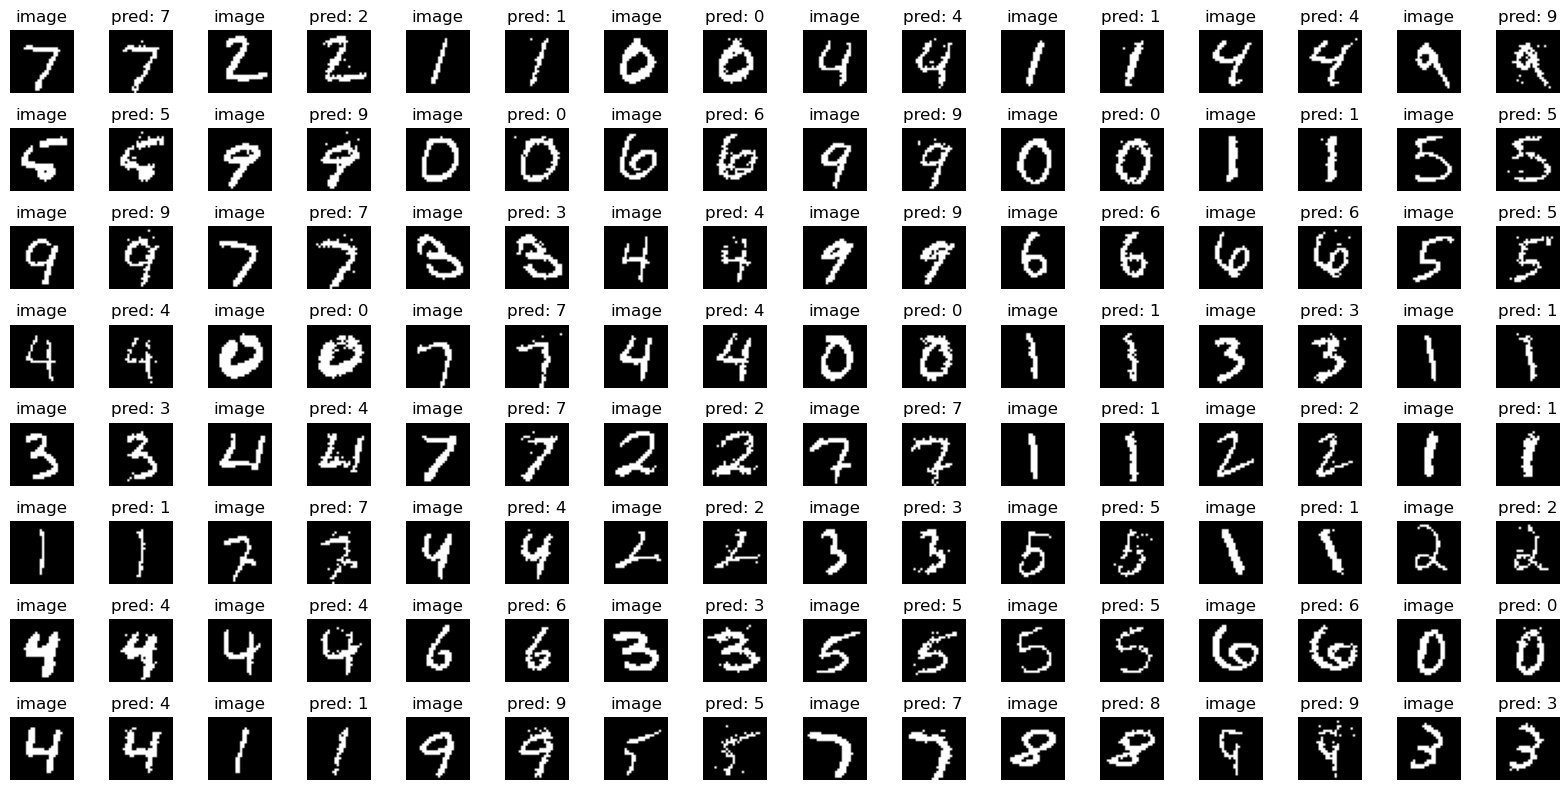

In [13]:
n_classes = 10
model = ConditionalPixelCNN(
    n_classes, in_channels=1, channels=64, out_channels=1, bn=False, conditional=False
).to(device)
model.load_state_dict(torch.load("./models/GatedPixelCNN.pt"))
reconstruct(model)

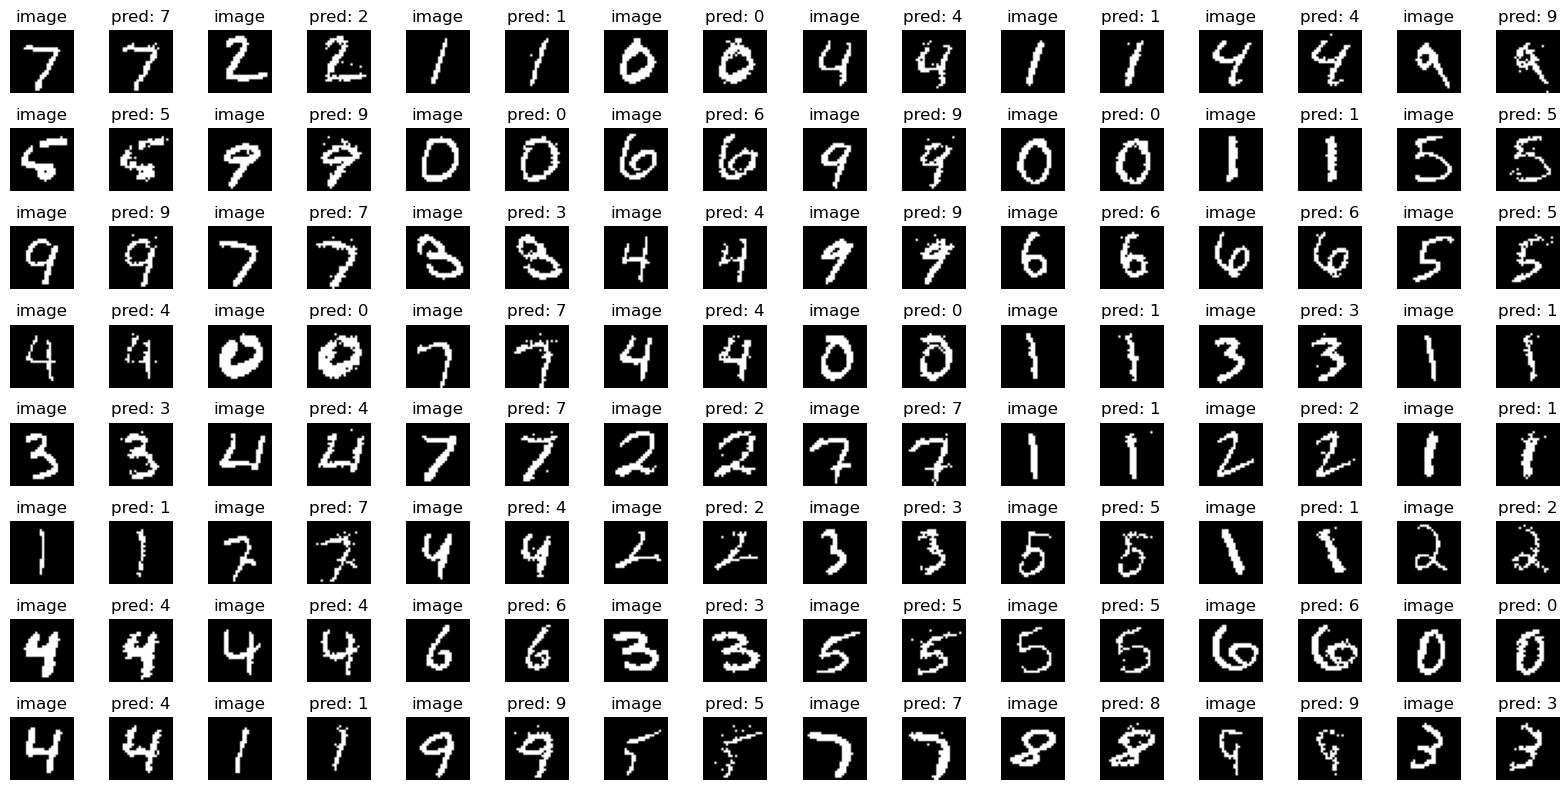

In [34]:
n_classes = 10
model = ConditionalPixelCNN(
    n_classes, in_channels=1, channels=64, out_channels=1, bn=True, conditional=False
).to(device)
model.load_state_dict(torch.load("./models/GatedPixelCNN_BN.pt"))
reconstruct(model)

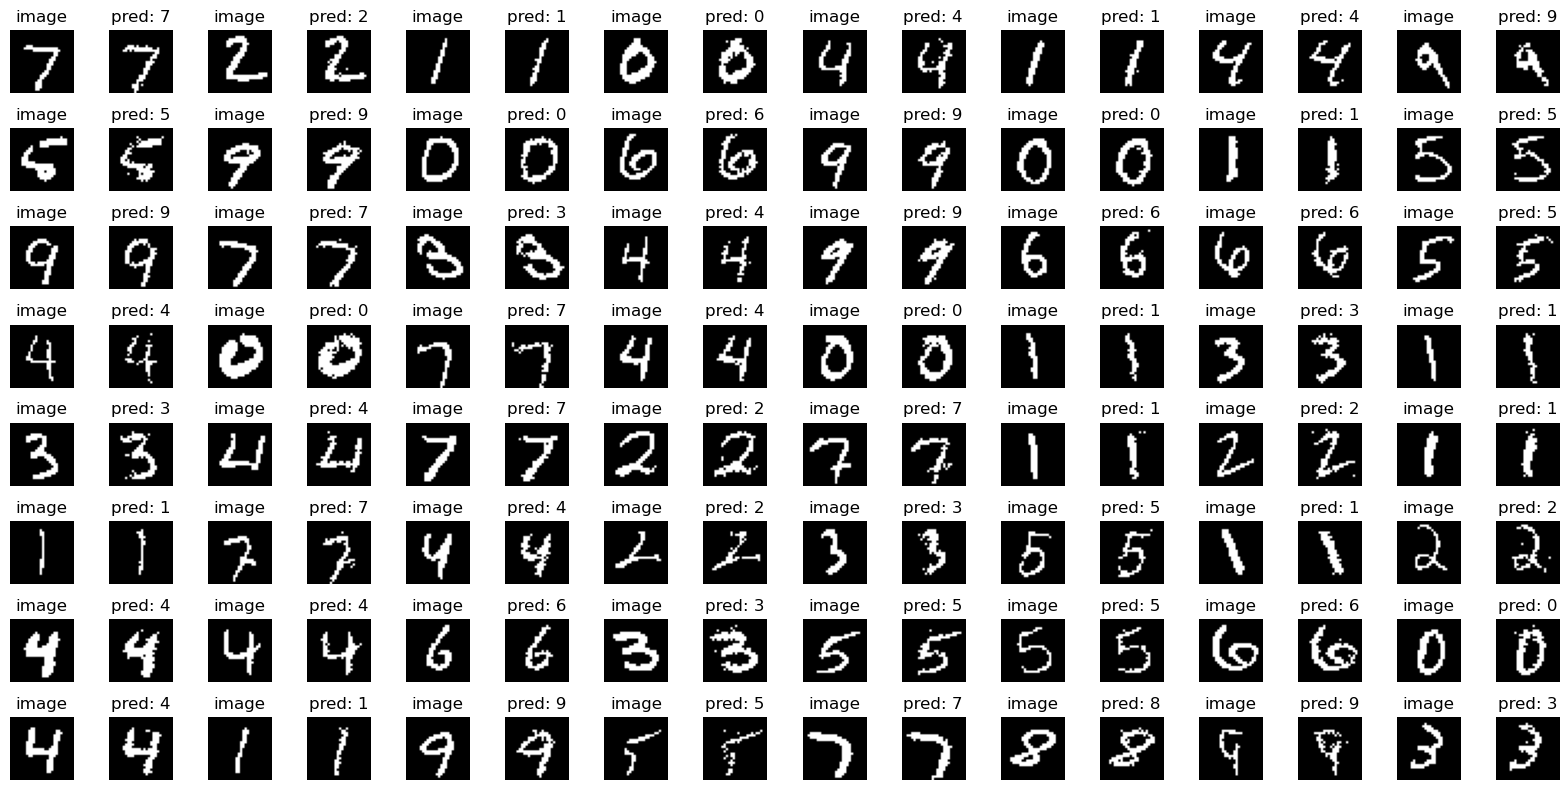

In [48]:
n_classes = 10
model = ConditionalPixelCNN(
    n_classes, in_channels=1, channels=64, out_channels=1, bn=False, conditional=True
).to(device)
model.load_state_dict(torch.load("./models/ConditionalPixelCNN.pt"))
reconstruct(model)

# f. Evaluation (Generation)

In [47]:
def generate(model):
    n_classes = 10
    samples = torch.zeros(size=(60, 1, H, W)).to(device)
    sample_classes = np.sort(np.array([np.arange(n_classes)] * 6).flatten())
    sample_classes = F.one_hot(torch.tensor(sample_classes, dtype=torch.int64), num_classes=n_classes).float().to(device)

    with torch.no_grad():
        for i in range(H):
            for j in range(W):
                if j > 0 and i > 0:
                    out = model(samples, sample_classes)
                    samples[:, :, i, j] = torch.bernoulli(out[:, :, i, j], out=samples[:, :, i, j])

    samples = samples.cpu().numpy().transpose(0, 2, 3, 1)
    fig, axes = plt.subplots(10, 6, figsize=(6, 10))

    for i in range(60):
        sample = samples[i]
        row, col = divmod(i, 6)
        axes[row, col].imshow(sample, cmap='gray')
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

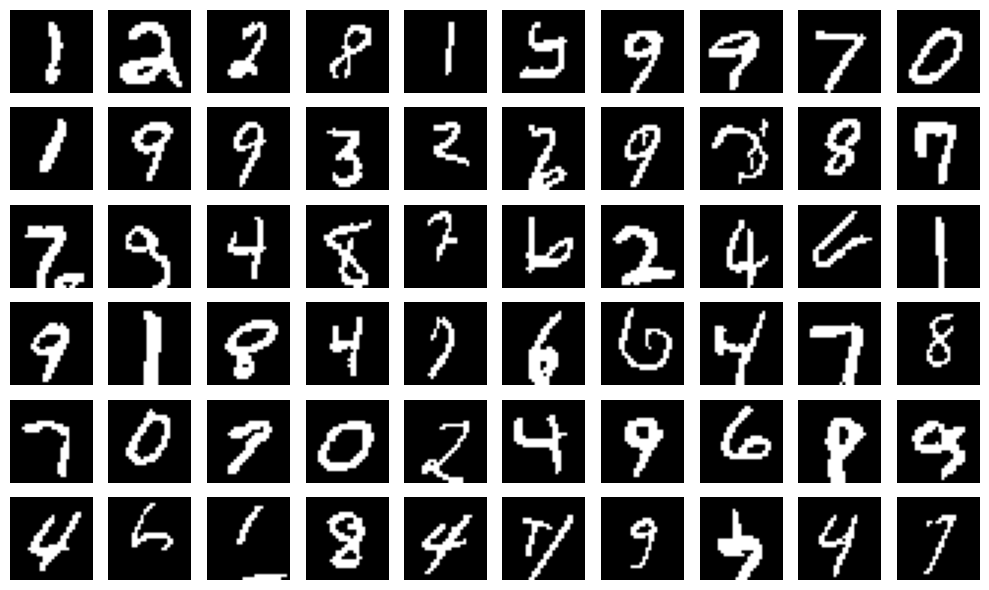

In [45]:
n_classes = 10
model = ConditionalPixelCNN(
    n_classes, in_channels=1, channels=64, out_channels=1, bn=False, conditional=False
).to(device)
model.load_state_dict(torch.load("./models/GatedPixelCNN.pt"))
generate(model)

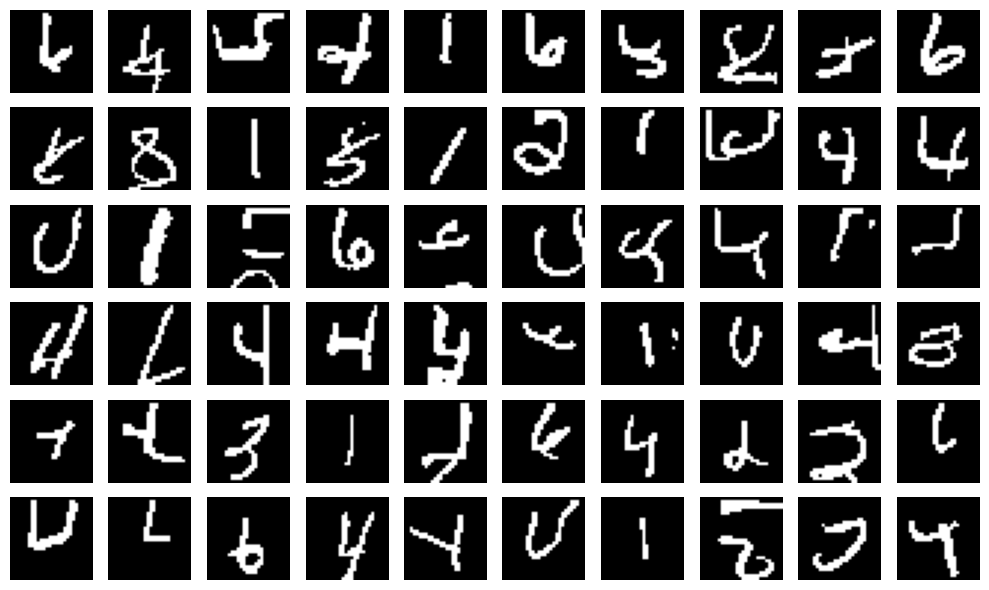

In [46]:
n_classes = 10
model = ConditionalPixelCNN(
    n_classes, in_channels=1, channels=64, out_channels=1, bn=True, conditional=False
).to(device)
model.load_state_dict(torch.load("./models/GatedPixelCNN_BN.pt"))
generate(model)

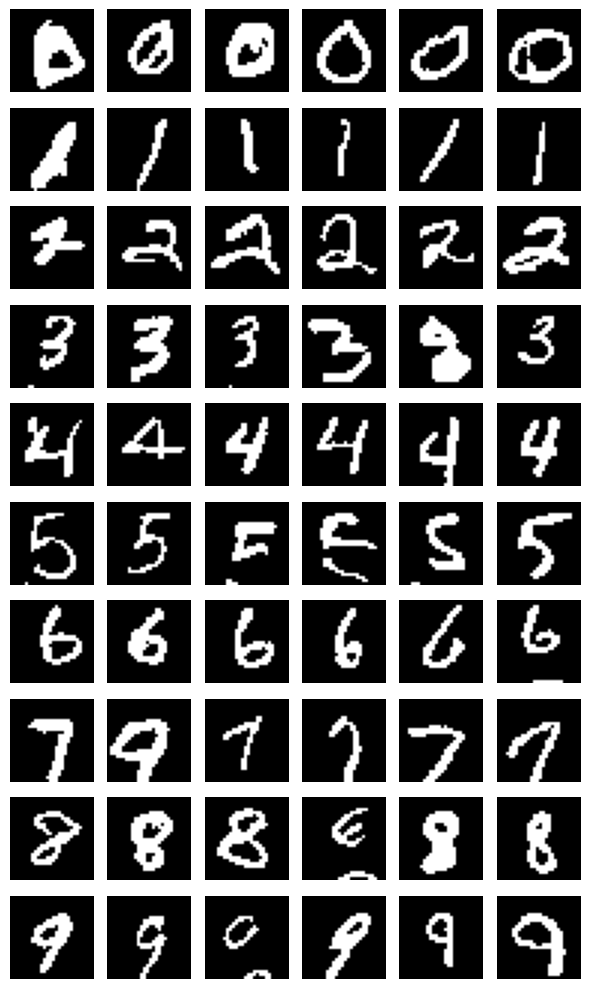

In [49]:
n_classes = 10
model = ConditionalPixelCNN(
    n_classes, in_channels=1, channels=64, out_channels=1, bn=False, conditional=True
).to(device)
model.load_state_dict(torch.load("./models/ConditionalPixelCNN.pt"))
generate(model)